In [1]:
import random
from functools import partial

from matplotlib import pyplot as plt
from matplotlib import colors

import numpy
import math

from deap import base
from deap import creator
from deap import tools
from deap import algorithms

In [38]:
GAME_SIZE = 10
ROW_RESTRICTIONS = [[4],[2],[3,6],[1,4,1],[10],[8],[1,2],[6],[4],[2]]
COLUMN_RESTRICTIONS = [[3],[1,2],[1,4],[1,3,2],[6,3],[6,3],[1,7],[1,4],[1,2],[3]]


In [3]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_binary", partial(random.randrange, 2))
toolbox.register("individual", tools.initRepeat, creator.Individual,
                 toolbox.attr_binary, n=GAME_SIZE**2)

In [4]:
#Fitness
def get_line_description(line):
    line_description = []
    add_split = True
    for i in range(len(line)):
        if line[i] == 1:
            if add_split:
                add_split = False
                line_description.append(1)
            else:
                line_description[-1] += 1
        else:
            add_split = True
    return line_description

def get_lines_description(individual):
    
    row_descriptions = []
    column_descriptions = []
    for i in range(GAME_SIZE):
        row = []
        column = []
        for j in range(GAME_SIZE):
            row.append(individual[i*10 + j*1])
            column.append(individual[i*1 + j*10])
        row_descriptions.append(get_line_description(row))
        column_descriptions.append(get_line_description(column))
        
    return row_descriptions, column_descriptions

def get_line_description_combinations(line_description):
    free_spaces = GAME_SIZE - sum(line_description) - (len(line_description) - 1)
    return math.factorial(free_spaces + len(line_description))/(math.factorial(len(line_description))*math.factorial(free_spaces))

def get_line_score(line, line_restriction):
    if line == line_restriction:
        value = 100
    else:
        value = 60 - abs(sum(line)-sum(line_restriction))*4.5 - abs(len(line)-len(line_restriction))
    
    return value * (1/(get_line_description_combinations(line_restriction))/(sum([1/get_line_description_combinations(a_line) for a_line in ROW_RESTRICTIONS+COLUMN_RESTRICTIONS])))
    #return value / (get_line_description_combinations(line_restriction)/sum([get_line_description_combinations(line) for line in ROW_RESTRICTIONS+COLUMN_RESTRICTIONS]))
    
def get_line_score2(line, line_restriction):
    if line == line_restriction:
        return 21
    else:
        return 20 - abs(sum(line)-sum(line_restriction)) - abs(len(line)-len(line_restriction))

def evaluate(individual):
    # Do some hard computing on the individual
    row_descriptions, column_descriptions = get_lines_description(individual)
    
    rows_score = 0
    columns_score = 0
    
    for i in range(GAME_SIZE):
        rows_score += get_line_score(row_descriptions[i], ROW_RESTRICTIONS[i])
        columns_score += get_line_score(column_descriptions[i], COLUMN_RESTRICTIONS[i])
    return rows_score + columns_score,

#Crossover
def cxOnePointLines(ind1, ind2):
    cxpoint = random.randrange(GAME_SIZE)
    ind1[cxpoint*GAME_SIZE+9:], ind2[cxpoint*GAME_SIZE+9:] = ind2[cxpoint*GAME_SIZE+9:], ind1[cxpoint*GAME_SIZE+9:]
    return ind1, ind2
    
def cxSwitchLines(ind1, ind2, indpb):
    line_multiplicators = [1,10] if random.randrange(2) else [10,1]
    
    for i in range(GAME_SIZE):
        if random.random() > indpb:
            line = []
            for j in range(GAME_SIZE):
                ind1[i*line_multiplicators[0] + j*line_multiplicators[1]], ind2[i*line_multiplicators[0] + j*line_multiplicators[1]] = ind2[i*line_multiplicators[0] + j*line_multiplicators[1]], ind1[i*line_multiplicators[0] + j*line_multiplicators[1]]
    
    return ind1, ind2

#Stats
def get_best(inds):
    try:
        fitness_values = [ind.fitness.values for ind in inds]
        return inds[fitness_values.index(max(fitness_values))]
    except:
        return None
    
def show_stats(logbook):

    draw_graphic(logbook)
    
    draw_evolution(logbook)        
    
            
def draw_individual(ind, title): 
    data = [ind[i:i+10] for i in range(0, len(ind)-9, 10)]
    
    cmap = colors.ListedColormap(['White','black'])
   
    plt.title(title, fontsize='large', loc='left')
    plt.pcolor(data[::-1],cmap=cmap,edgecolors='k', linewidths=3)
    plt.axis('off')
    
def draw_graphic(logbook): 
    gen = logbook.select("gen")
    fit_max = logbook.chapters["fitness"].select("max")
    
    
    fig, ax1 = plt.subplots(figsize=(20,10))
    plt.title("Fitness evolution", {'fontsize': 20, 'fontweight' : 20})
    line1 = ax1.plot(gen, fit_max, "g", label="Maximum Fitness")
    ax1.set_xlabel("Generation")
    ax1.set_ylabel("Fitness", color="g")
    for tl in ax1.get_yticklabels():
        tl.set_color("g")
    lns = line1 
    labs = [l.get_label() for l in lns]
    ax1.legend(lns, labs, loc="center right")

    
    plt.show()
    
def draw_evolution(logbook):
    ind_logs = logbook.chapters["individual"].select("first")
    step = max(1, int(len(ind_logs)/50))
    for i in range(int(len(logbook)/(step*5))+1):
        fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(20,3.8))
        for j, ax in enumerate(axs.flatten()):
            plt.sca(ax)
            index = i*5*step+j*step
            if index < len(ind_logs):
                draw_individual(ind_logs[index], "Gen " + str(index) + "\n" + "Fitness: " + str(ind_logs[index].fitness.values[0]))
            else: plt.axis('off')
        plt.show()

In [40]:
run_config1 = {
    "evaluate_method": evaluate,
    "evaluate_parameters": {},
    "crossover_method": tools.cxTwoPoint, 
    "crossover_parameters": {},
    "mutation_method": tools.mutFlipBit,  
    "mutation_parameters": {"indpb": 0.1},
    "selection_method": tools.selTournament,  
    "selection_parameters": {"tournsize": 3},
    "individuals_ammount": 500,  
    "hall_of_fame_size": 1,
    "crossover_chance": 0.9,  
    "mutation_chance": 0.2,  
    "n_generations": 600,  
}

run_config2 = {
    "evaluate_method": evaluate,
    "evaluate_parameters": {},
    "crossover_method": tools.cxTwoPoint,
    "crossover_parameters": {},
    "mutation_method": tools.mutFlipBit,
    "mutation_parameters": {"indpb": 0.1},
    "selection_method": tools.selTournament,
    "selection_parameters": {"tournsize": 3},
    "individuals_ammount": 500,
    "hall_of_fame_size": 1,
    "crossover_chance": 0.8,
    "mutation_chance": 0.4,
    "n_generations": 600
}

run_config3 = {
    "evaluate_method": evaluate,
    "evaluate_parameters": {},
    "crossover_method": tools.cxTwoPoint,
    "crossover_parameters": {},
    "mutation_method": tools.mutShuffleIndexes,
    "mutation_parameters": {"indpb": 0.1},
    "selection_method": tools.selTournament,
    "selection_parameters": {"tournsize": 3},
    "individuals_ammount": 500,
    "hall_of_fame_size": 1,
    "crossover_chance": 0.8,
    "mutation_chance": 0.4,
    "n_generations": 600
}

run_config4 = {
    "evaluate_method": evaluate,
    "evaluate_parameters": {},
    "crossover_method": cxSwitchLines,
    "crossover_parameters": {"indpb": 0.8},
    "mutation_method": tools.mutShuffleIndexes,
    "mutation_parameters": {"indpb": 0.1},
    "selection_method": tools.selTournament,
    "selection_parameters": {"tournsize": 3},
    "individuals_ammount": 500,
    "hall_of_fame_size": 1,
    "crossover_chance": 0.8,
    "mutation_chance": 0.4,
    "n_generations": 600
}

run_config5 = {
    "evaluate_method": evaluate,
    "evaluate_parameters": {},
    "crossover_method": cxSwitchLines,
    "crossover_parameters": {"indpb": 0.8},
    "mutation_method": tools.mutShuffleIndexes,
    "mutation_parameters": {"indpb": 0.1},
    "selection_method": tools.selTournament,
    "selection_parameters": {"tournsize": 3},
    "individuals_ammount": 1000,
    "hall_of_fame_size": 1,
    "crossover_chance": 0.8,
    "mutation_chance": 0.4,
    "n_generations": 500
}

In [5]:
def run_algorithm(run_config):

    toolbox.register("evaluate", run_config["evaluate_method"], **run_config["evaluate_parameters"])
    toolbox.register("mate", run_config["crossover_method"], **run_config["crossover_parameters"])
    toolbox.register("mutate", run_config["mutation_method"], **run_config["mutation_parameters"])
    toolbox.register("select", run_config["selection_method"], **run_config["selection_parameters"])

    stats_fit = tools.Statistics(key=lambda ind: ind.fitness.values)
    stats_ind = tools.Statistics(key=lambda ind: ind)
    stats = tools.MultiStatistics(fitness=stats_fit, individual = stats_ind)

    stats.register("avg", numpy.mean, axis=0)
    stats.register("std", numpy.std, axis=0)
    stats.register("min", numpy.min, axis=0)
    stats.register("max", numpy.max, axis=0)
    stats.register("first", get_best)
    

    individuals = []
    for i in range(run_config["individuals_ammount"]):
        individuals.append(toolbox.individual())

    hall_of_fame = tools.HallOfFame(run_config["hall_of_fame_size"])

    print("Running model")
    results, logbook = algorithms.eaSimple(individuals, toolbox, run_config["crossover_chance"], run_config["mutation_chance"], run_config[ "n_generations"], halloffame = hall_of_fame, stats=stats, verbose=False)

    for i in range(len(hall_of_fame)):
        plt.figure(figsize = [4,4])
        draw_individual(hall_of_fame[i], "Best individual:" + "\n" + "Fitness: " + str(hall_of_fame[i].fitness.values[0]))
        plt.show
        
    print("Generating stats")
    show_stats(logbook)
    
    return results, logbook

Running model
Generating stats


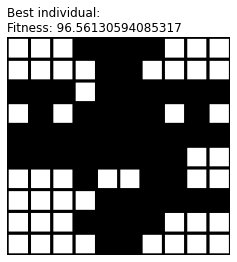

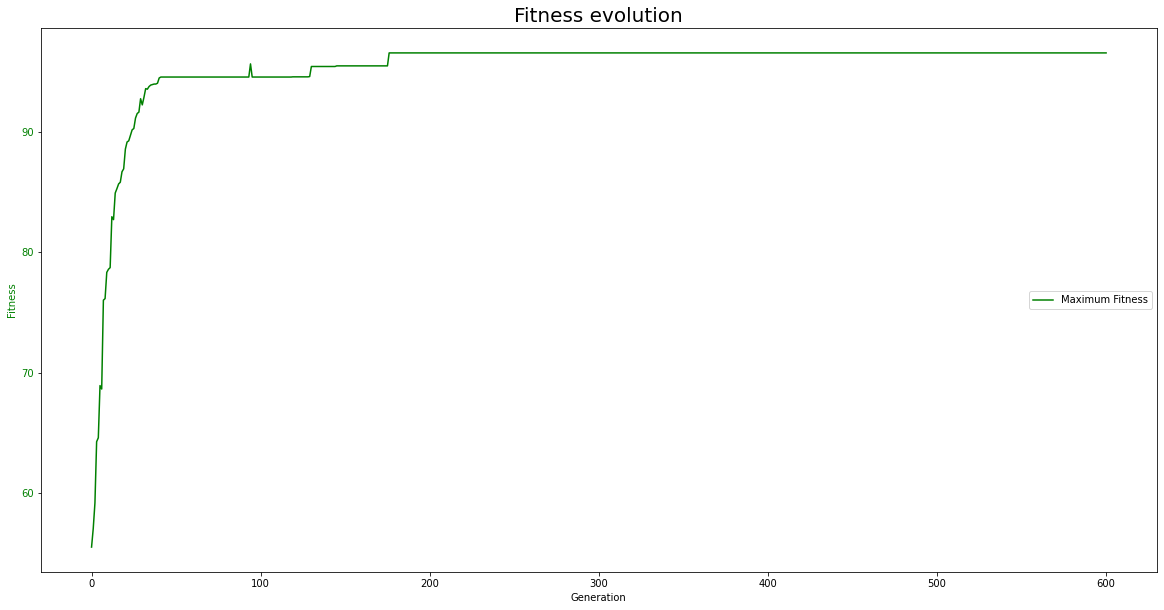

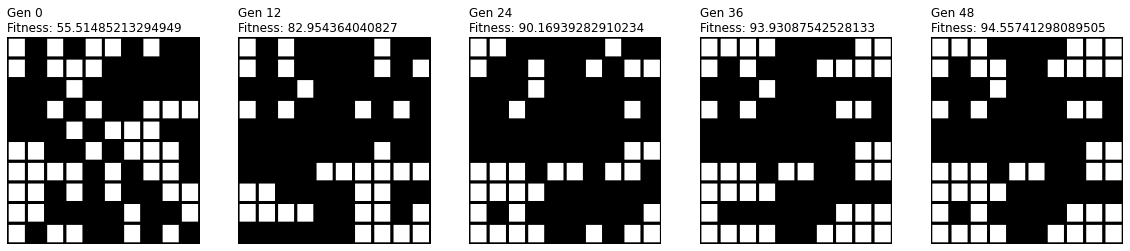

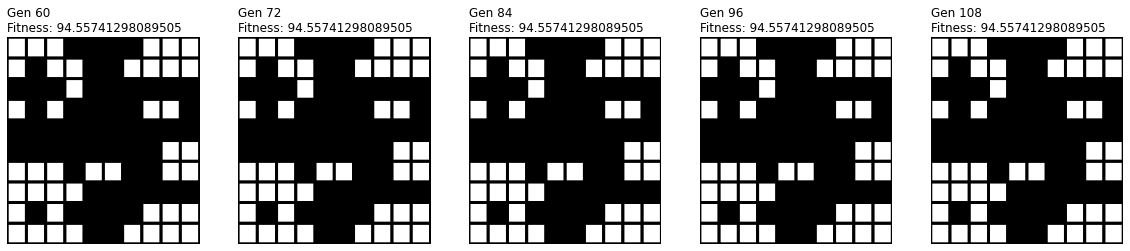

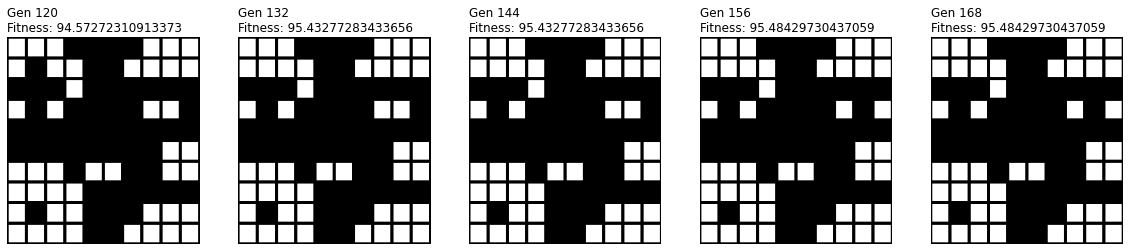

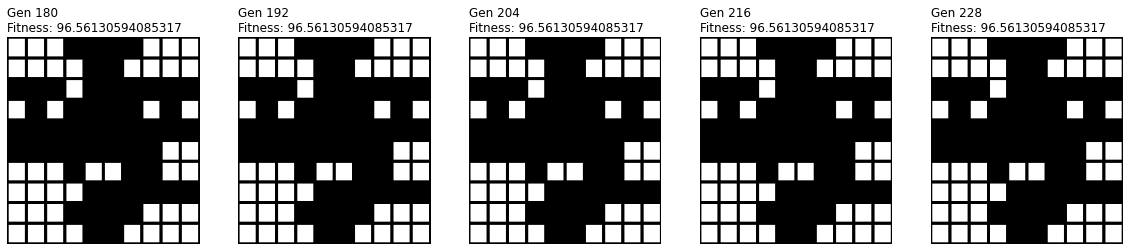

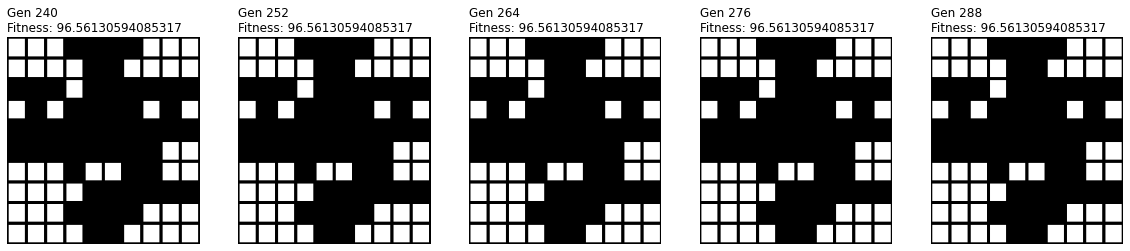

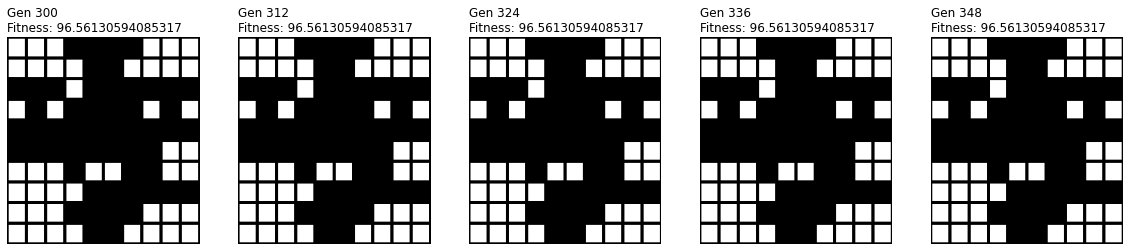

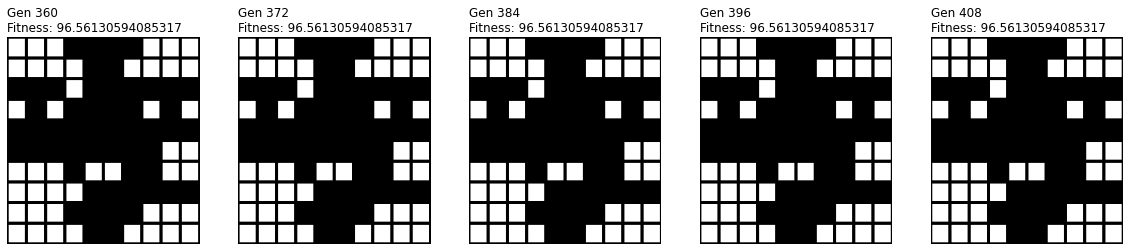

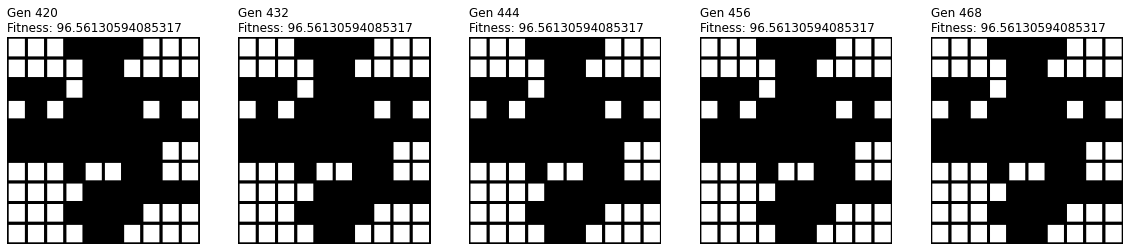

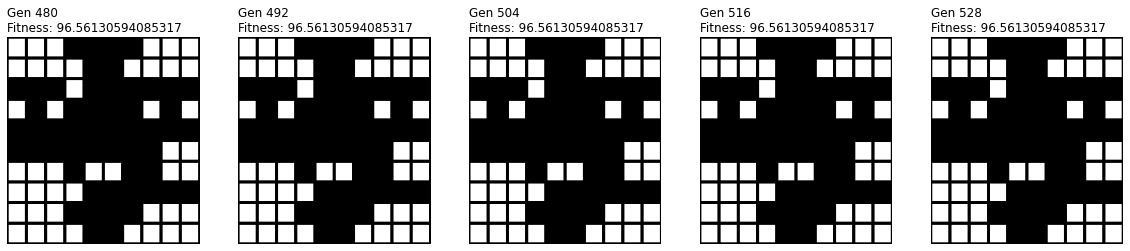

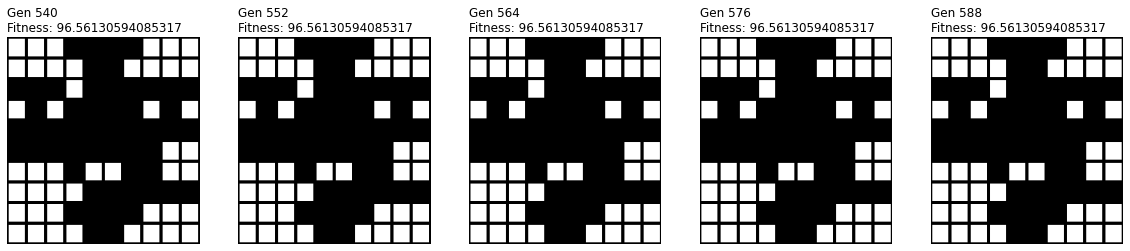

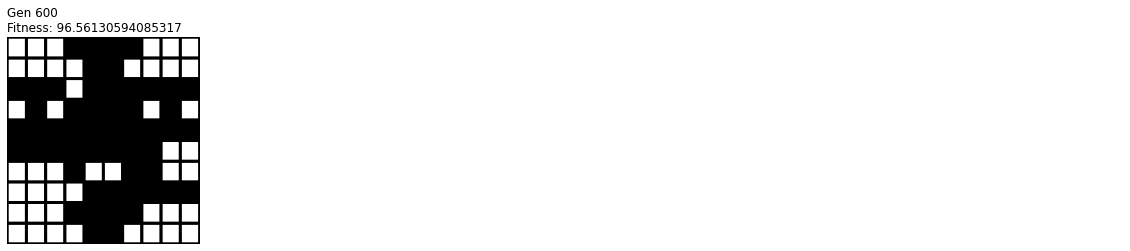

In [43]:
result_population, logbook = run_algorithm(run_config1)

Running model
Generating stats


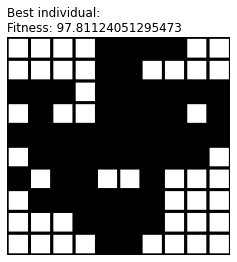

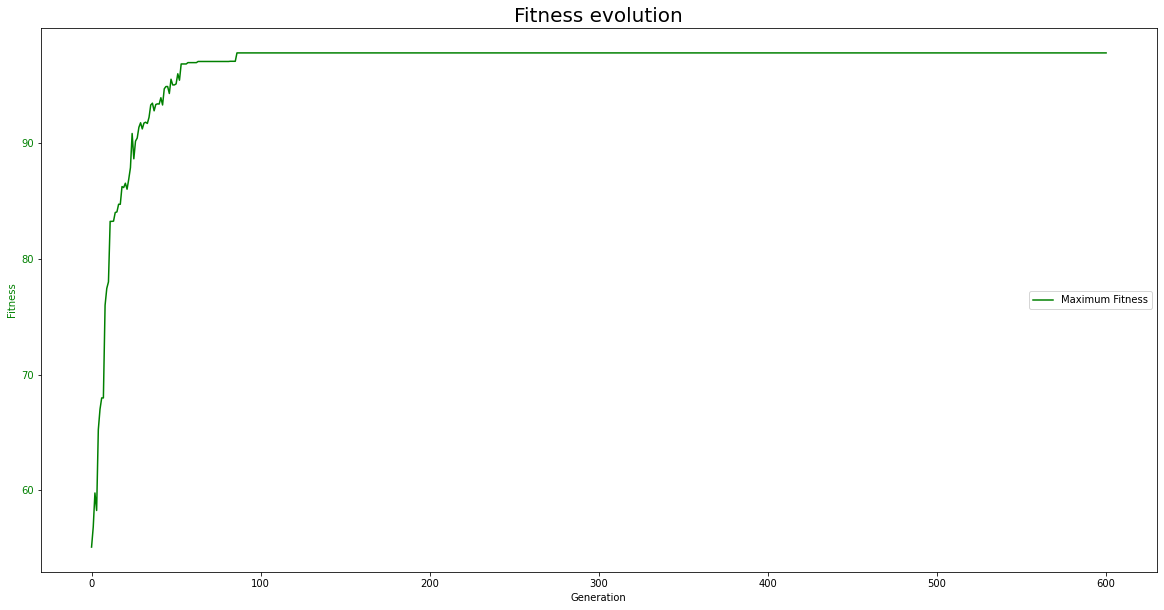

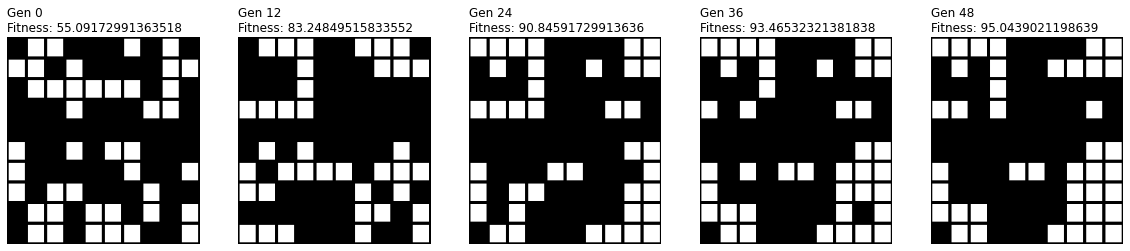

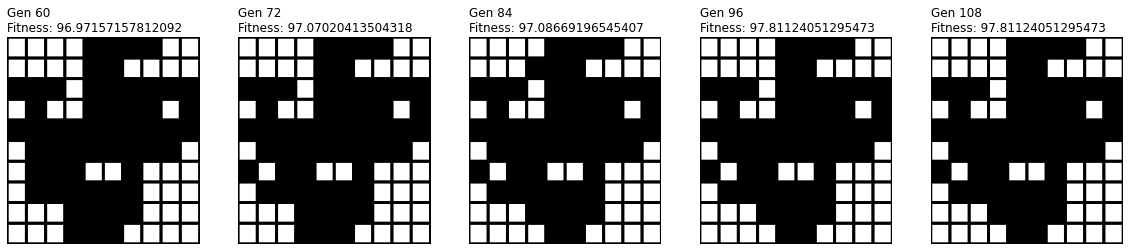

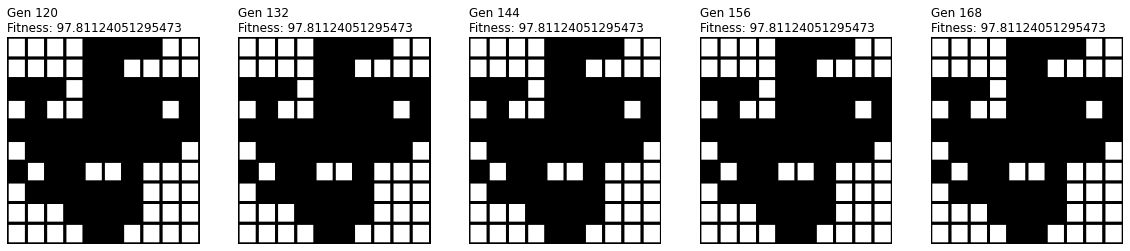

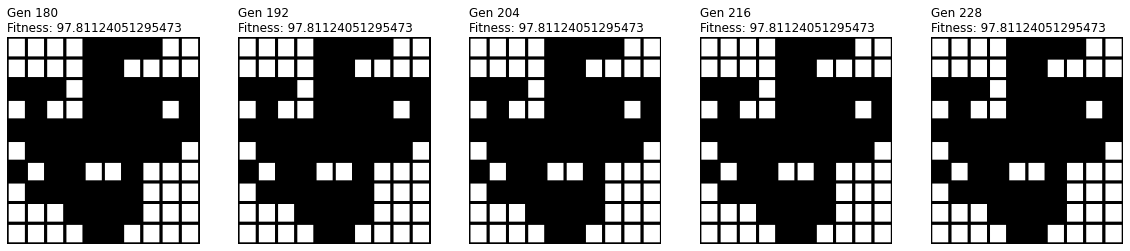

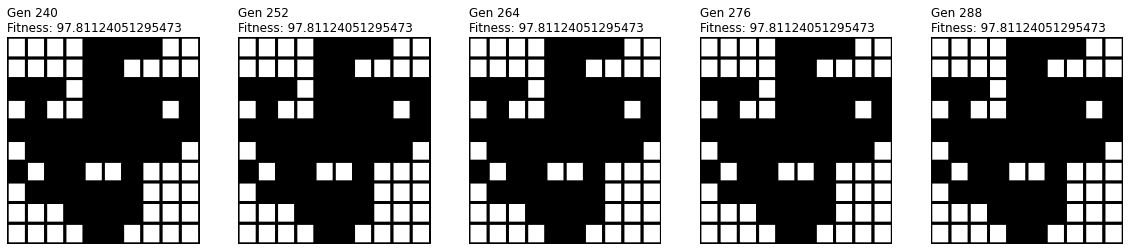

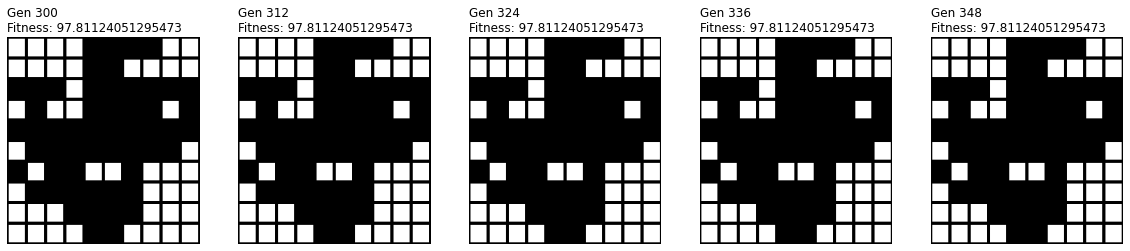

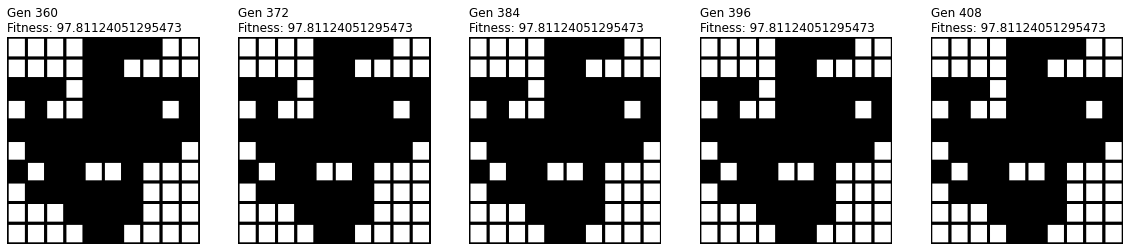

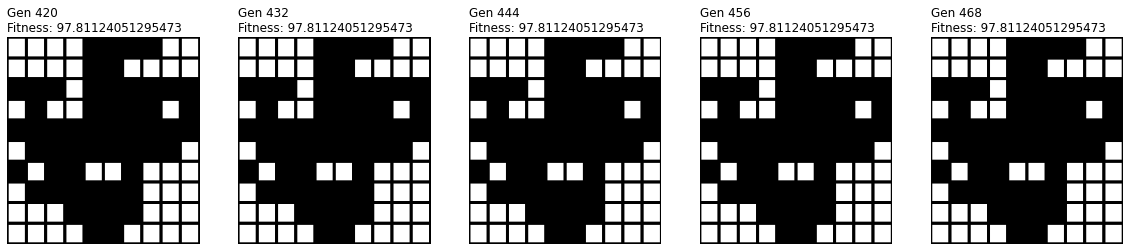

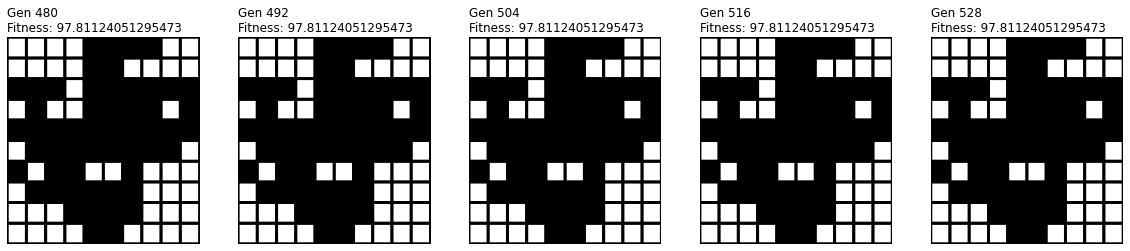

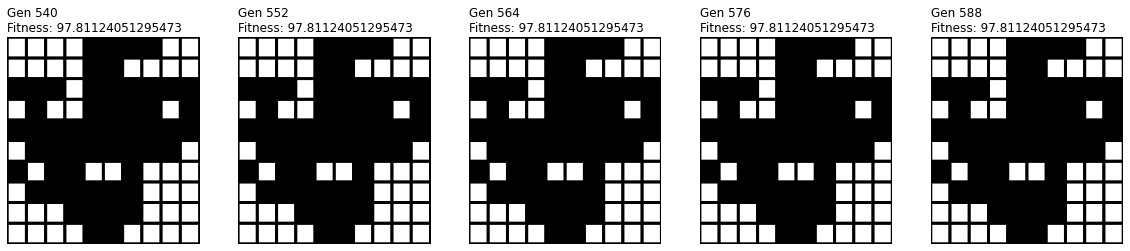

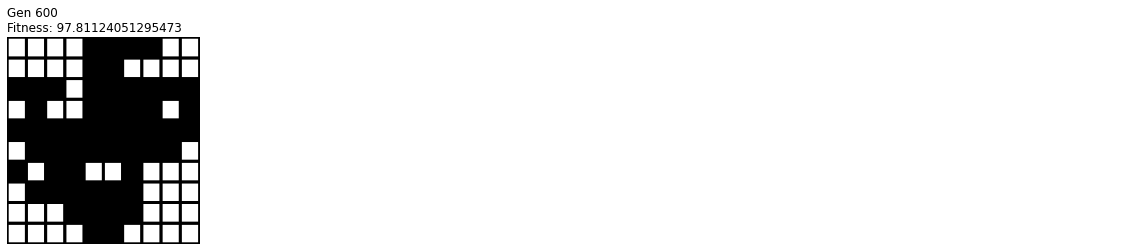

In [42]:
result_population, logbook = run_algorithm(run_config2)

Running model
Generating stats


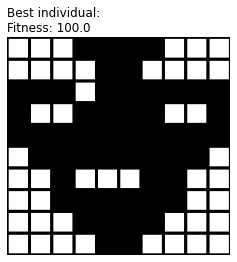

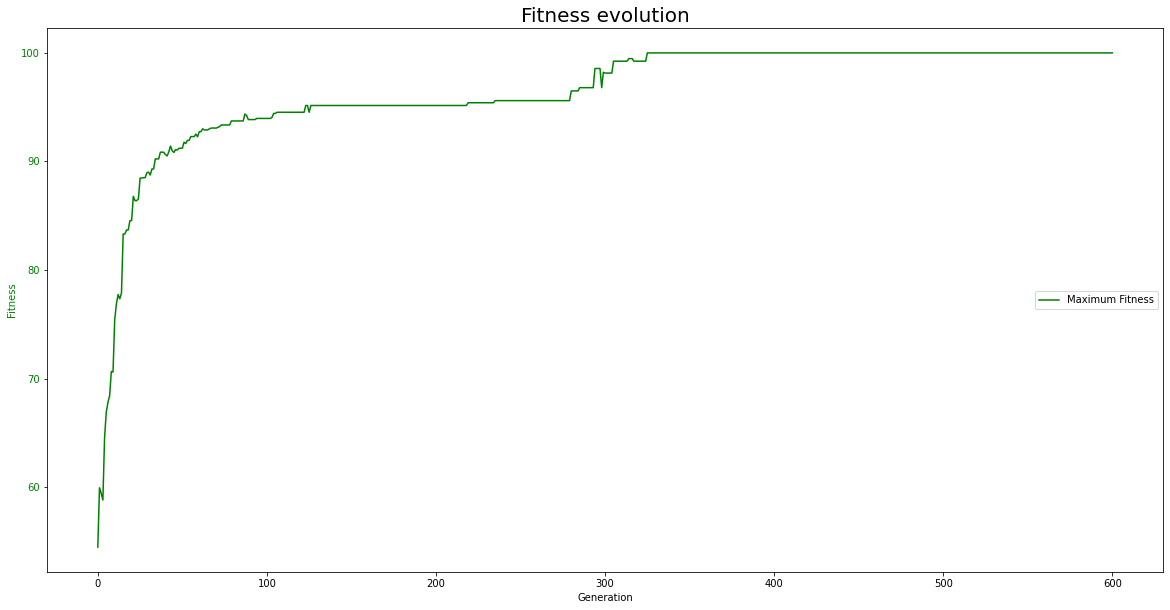

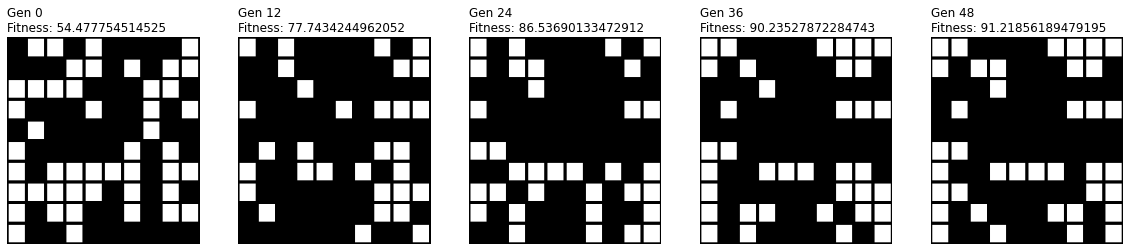

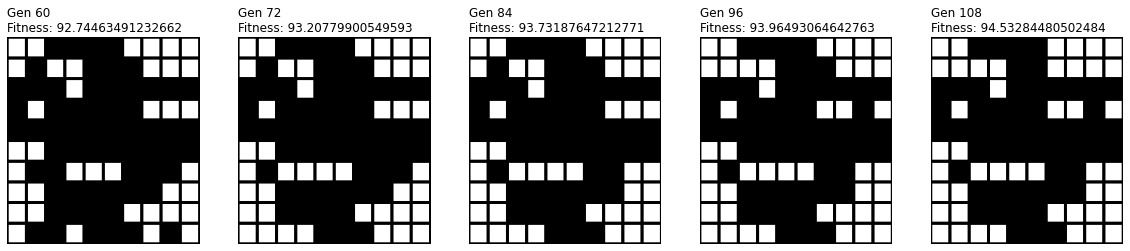

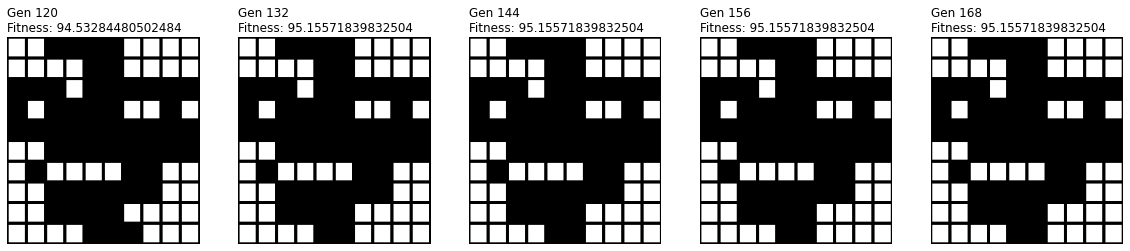

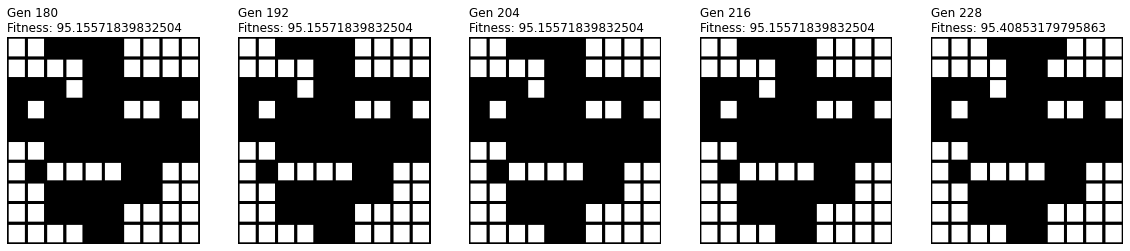

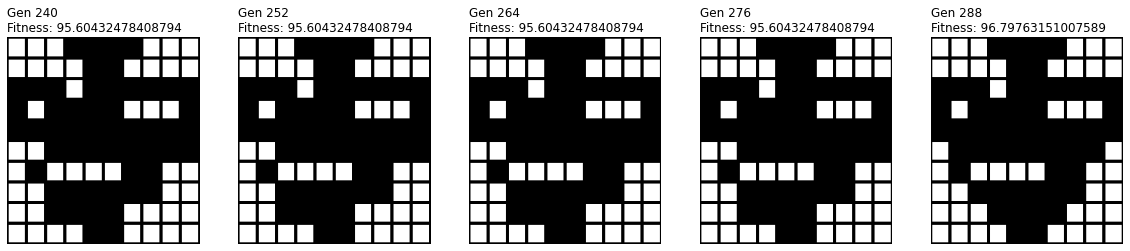

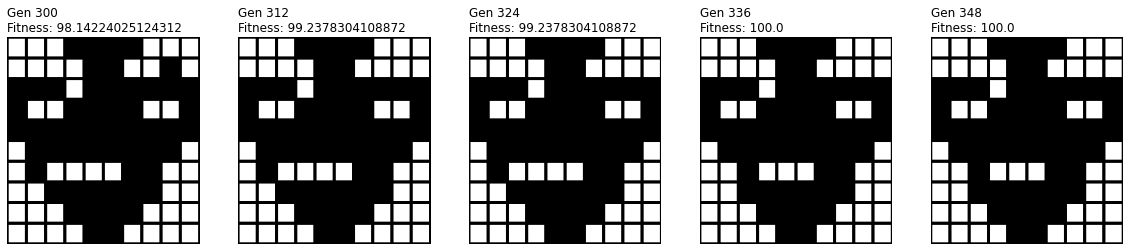

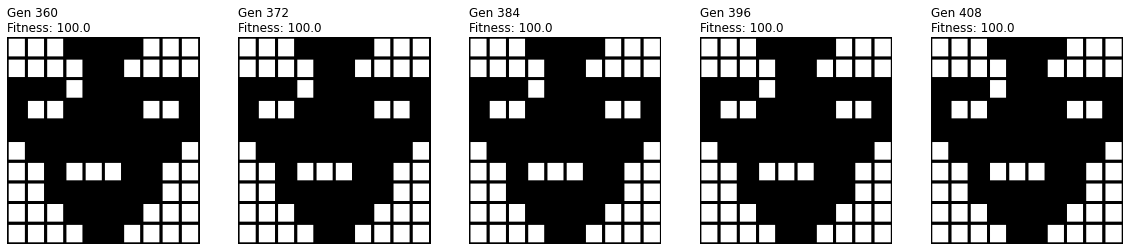

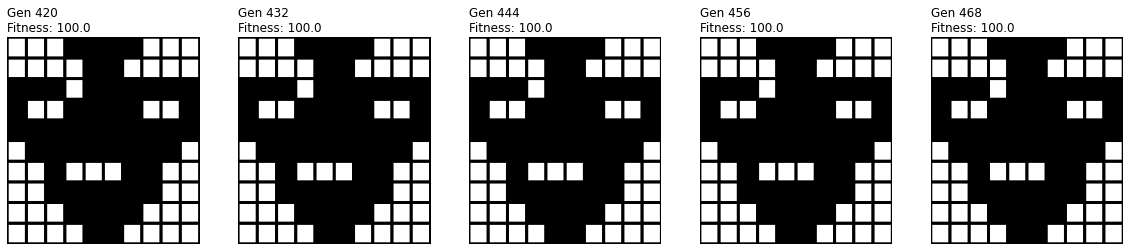

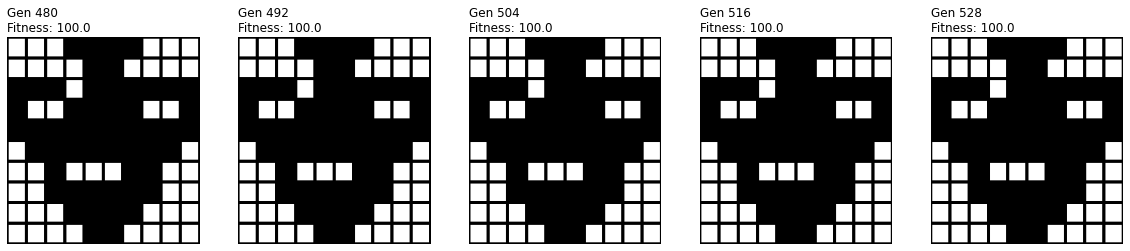

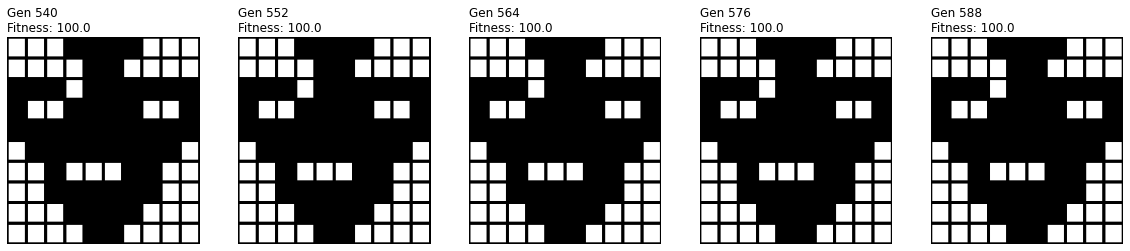

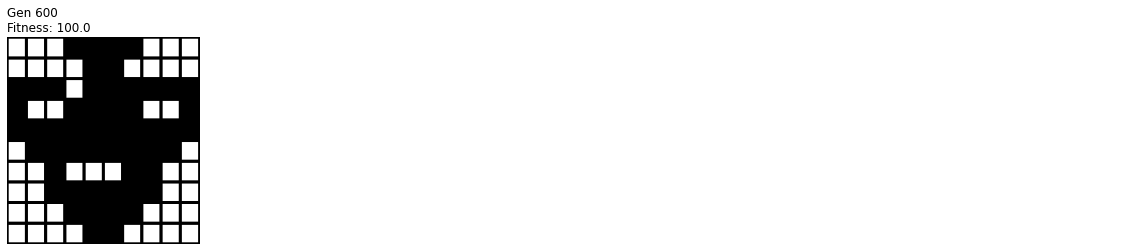

In [41]:
result_population, logbook = run_algorithm(run_config3)

Running model
Generating stats


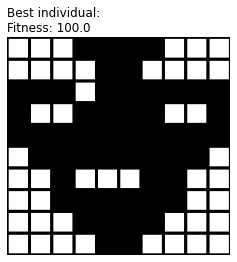

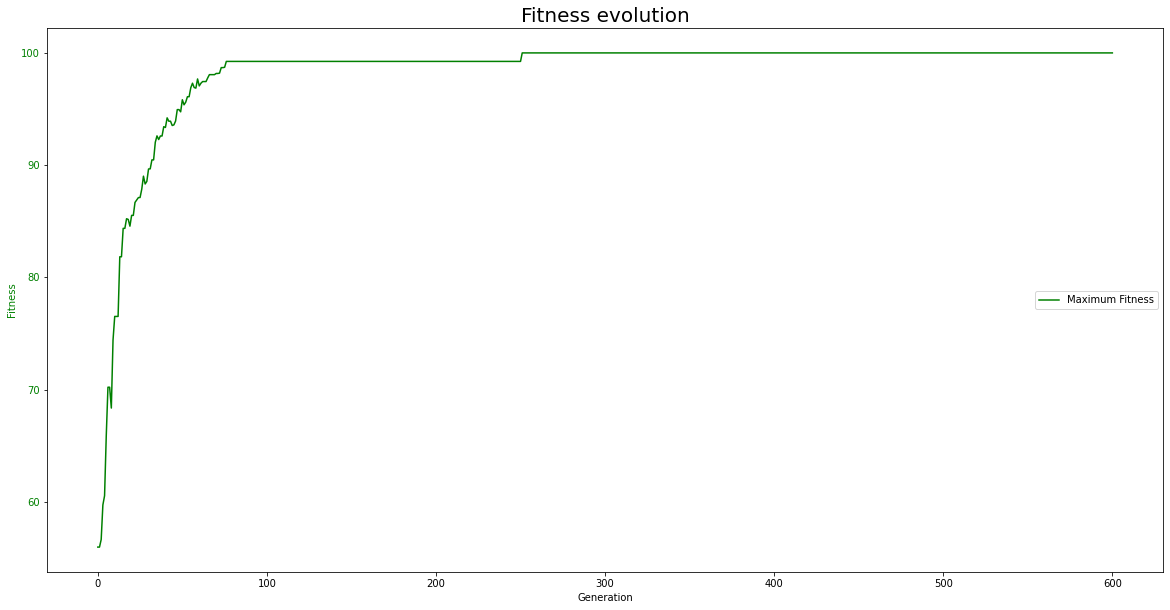

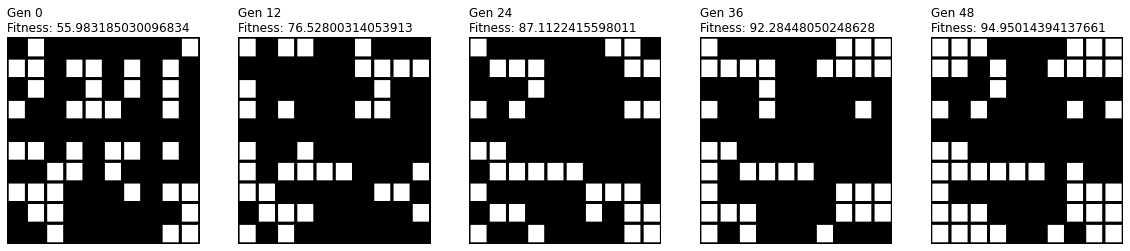

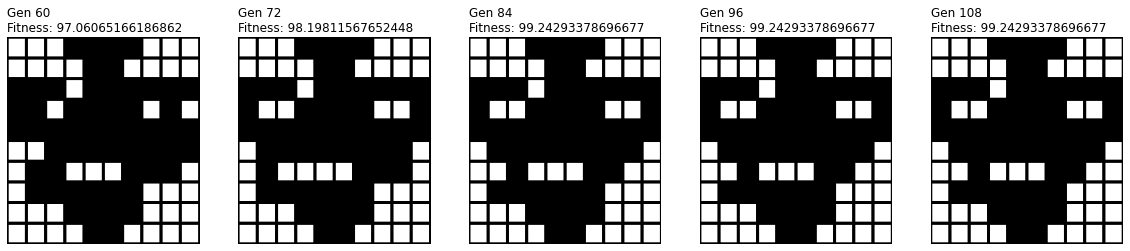

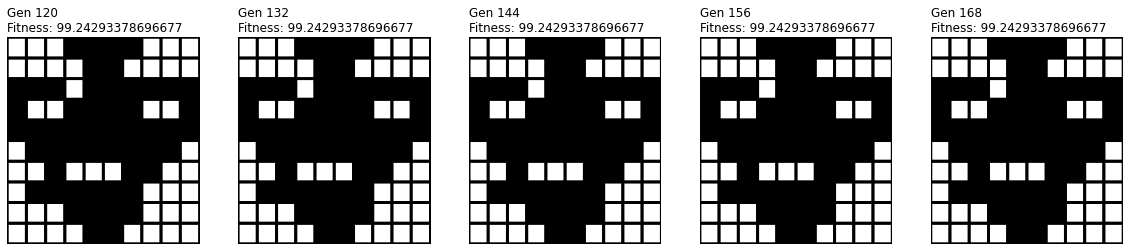

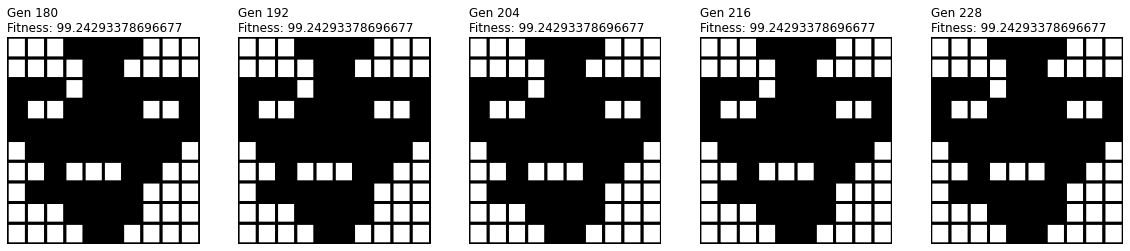

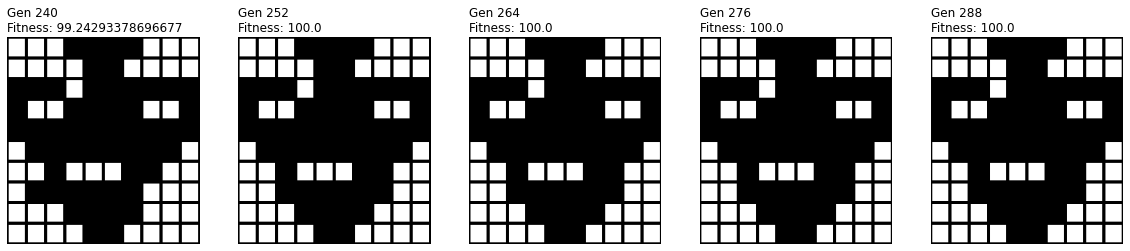

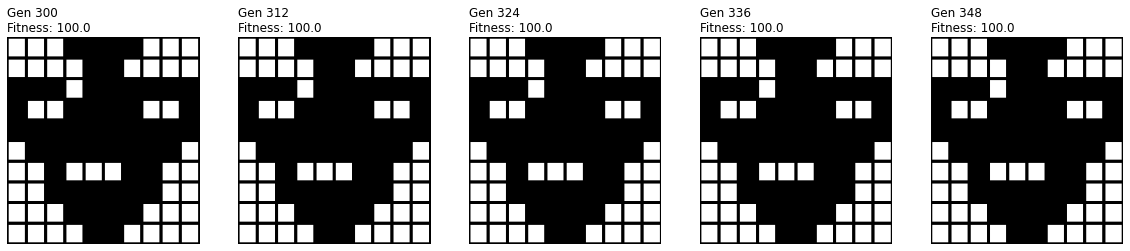

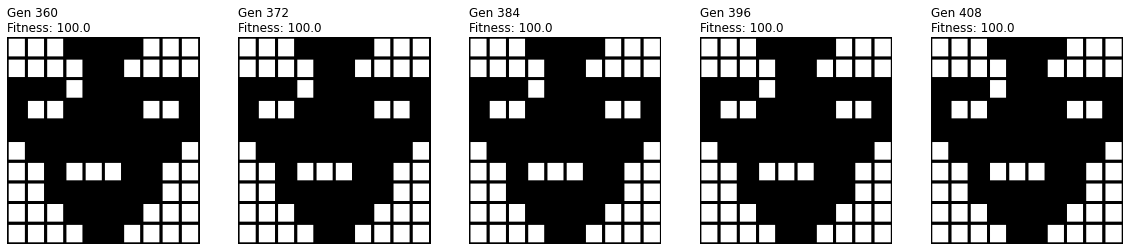

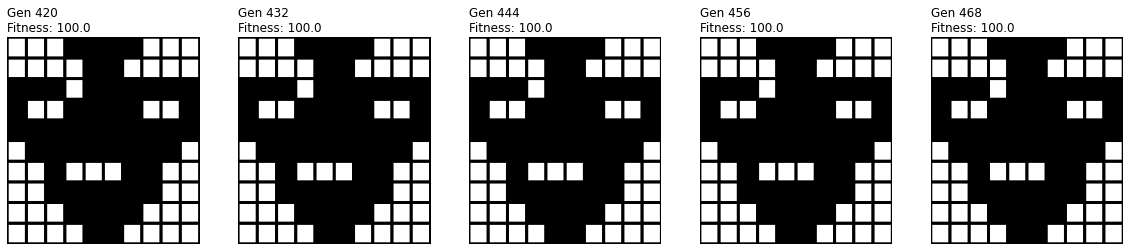

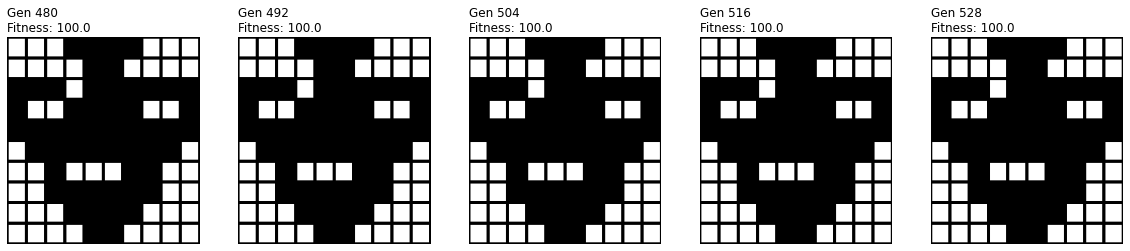

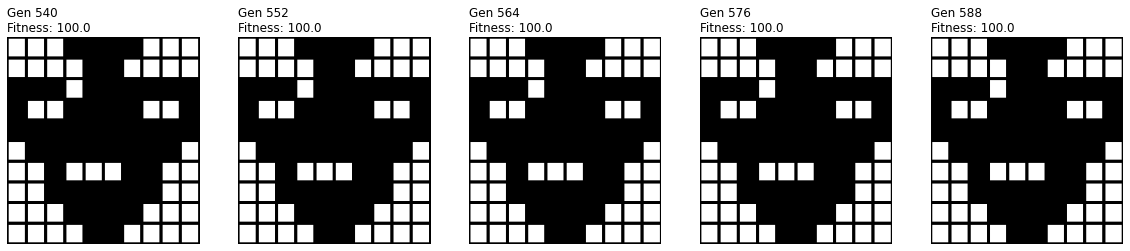

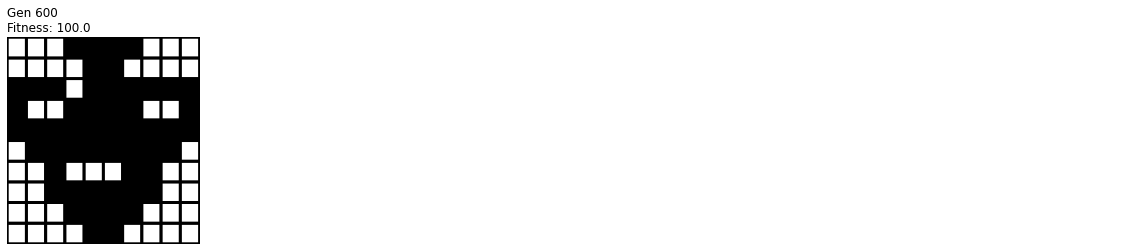

In [45]:
result_population, logbook = run_algorithm(run_config4)

Running model
Generating stats


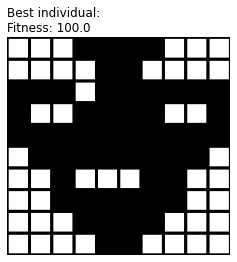

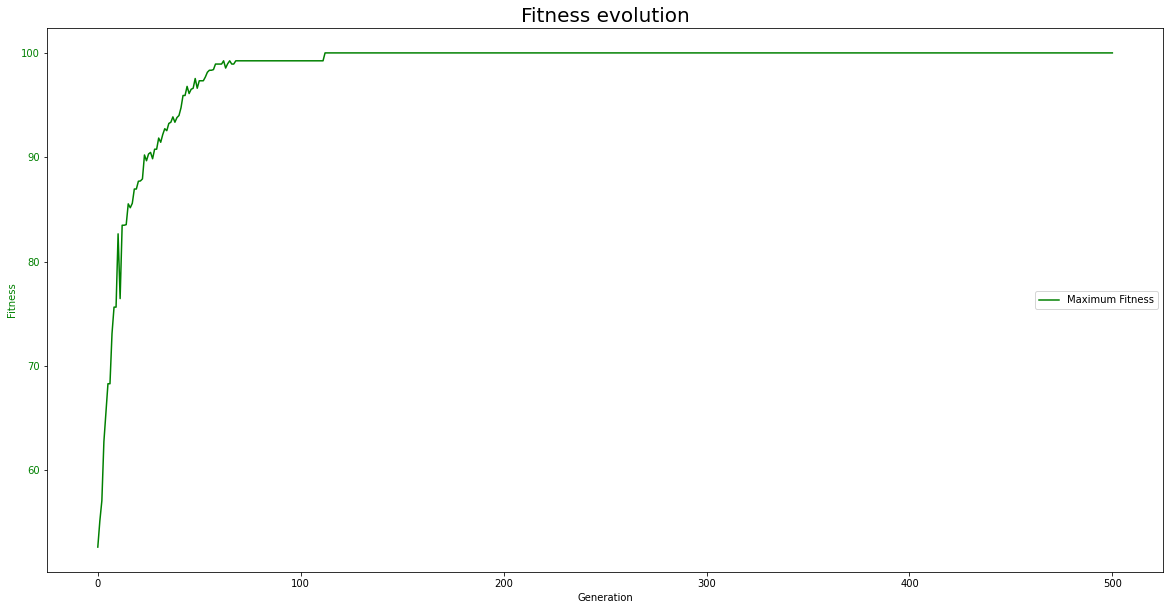

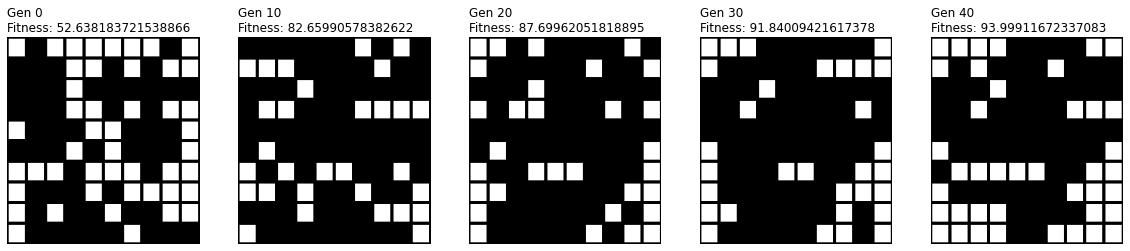

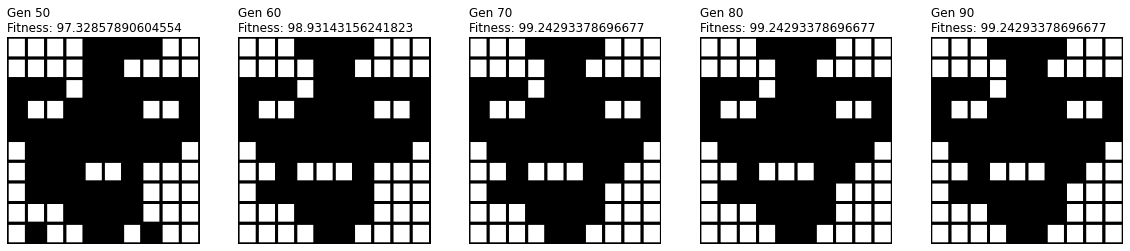

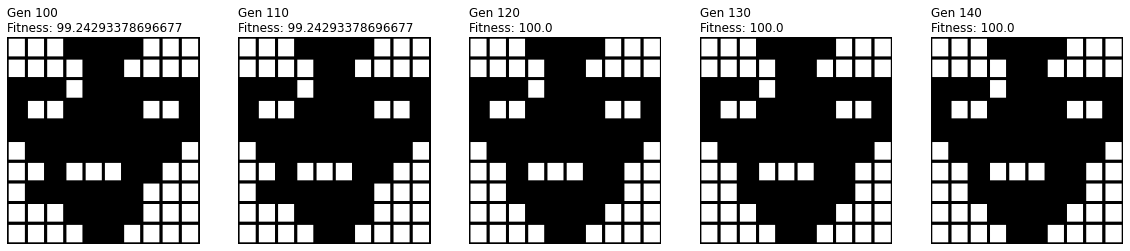

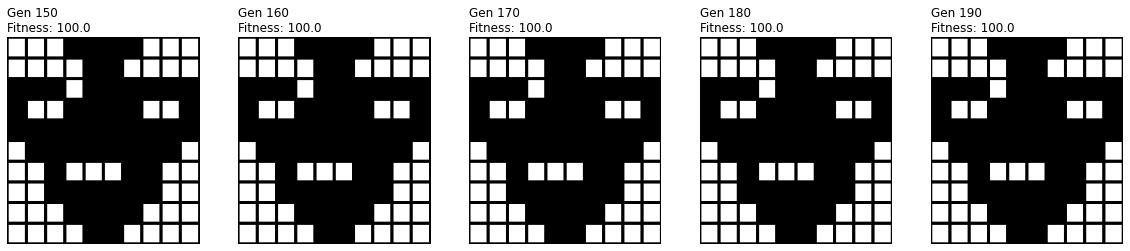

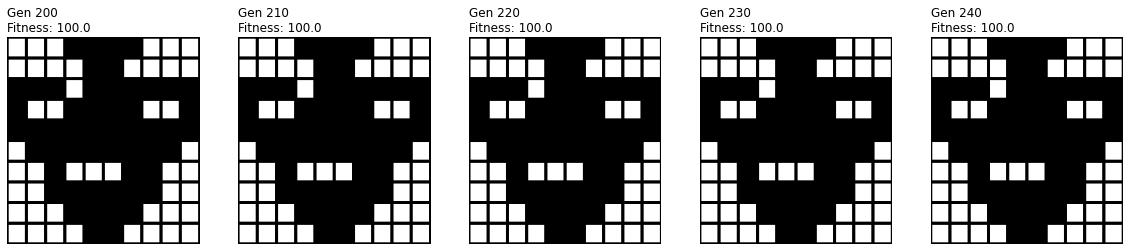

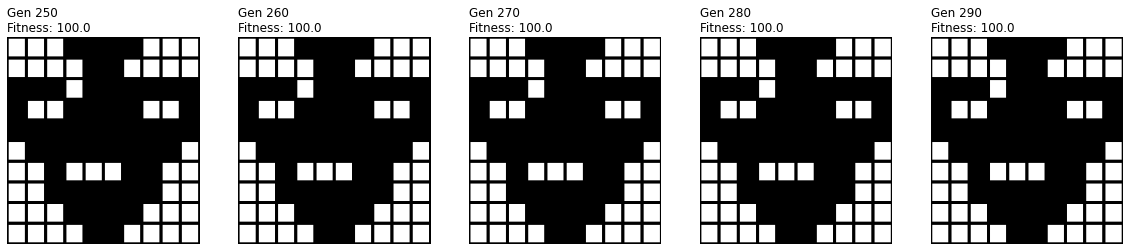

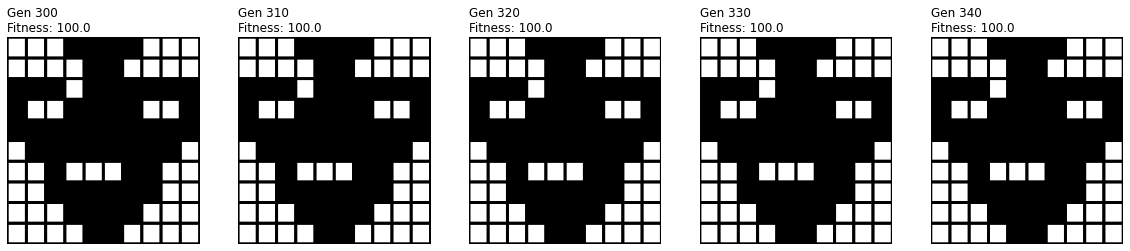

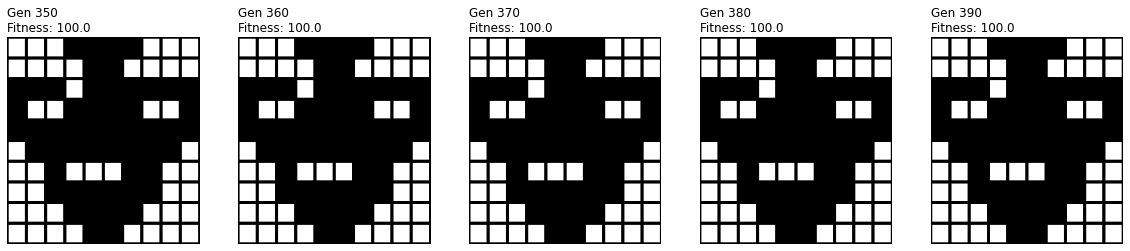

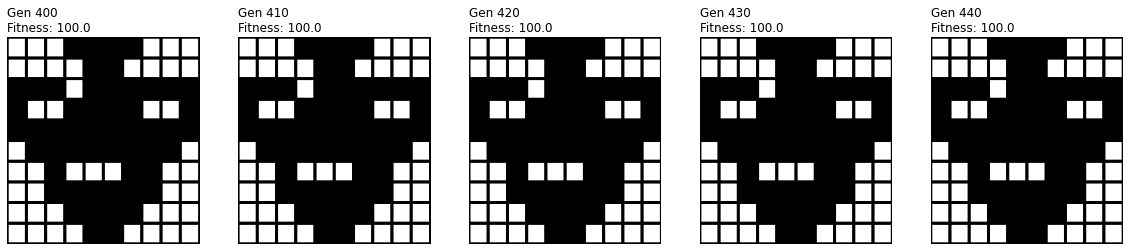

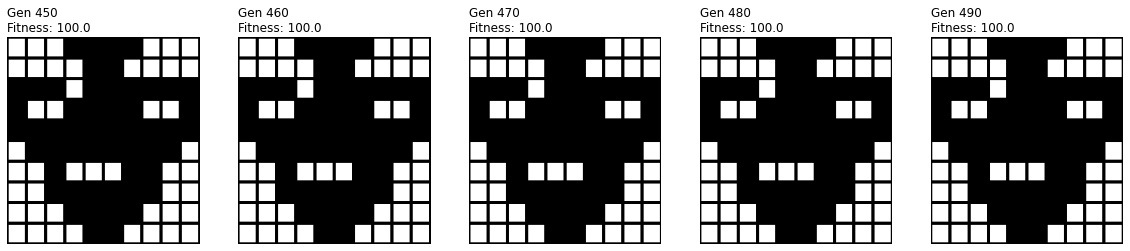

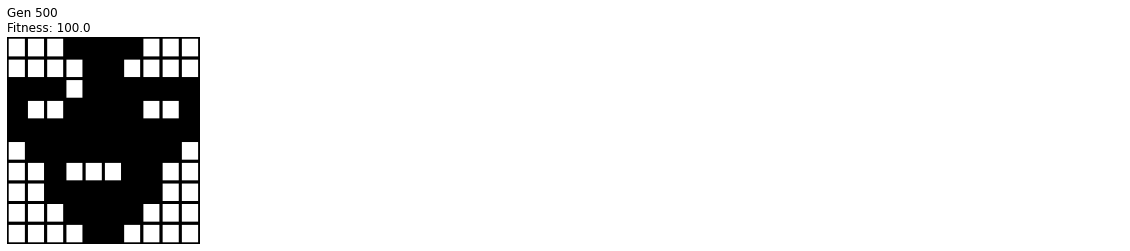

In [44]:
result_population, logbook = run_algorithm(run_config5)